In [1]:
import pandas as pd

In [2]:
# Wczytanie danych od Shumee
df_org = pd.read_excel('shumee_mckinsey -Aktualizacja 01.03.xlsx', index_col=None, engine='openpyxl') 

### Czyszczenie danych

In [3]:
def finder(phrase):
    return (lambda product_name : str(product_name).find(phrase))

df = df_org[df_org['ID zamówienia'].notna()] # usunięcie wpisów gdzie ID zamówienia == NaN
df = df[df['Nazwa produktu'] != 'Przesyłka pobraniowa']
df = df[df['Nazwa produktu'].map(finder("Kod rabatowy")) == -1] # usuniecie kodow rabatowych
df = df[df['Miasto'] != 'test']
df = df[df['Miasto'] != 'Test']
df = df[df['Miasto'] != 'TEST']
df = df[df['Miasto'] != 'ssss']
df = df[df['Miasto'] != 'asd']
df = df[df['Miasto'] != 'asdasd']
df = df[df['Miasto'] != 'dsss']
df = df[df['Nazwa produktu'].map(finder("TESTOWY PRODUKT")) == -1]
df = df[df['Nazwa produktu'].map(finder("PRODUKT TESTOWY")) == -1]
df = df[df['Cena'] >= 0] # usuniecie kodow rabatowych
# akceptuję produkty z ceną 0 zł, ponieważ są to produkty zamówione osobiście lub też telefonicznie

Na razie ograniczę się tylko do produktów sprzedanych w Polsce:

In [4]:
df = df[df["Kraj"]=="PL"]

Tworzę nową kolumnę "Uproszczona nazwa produktu", zawierającą nazwy produktów z wyrzuconymi słowami, które uznaję za niistotne do kategoryzacji produtków

In [5]:
import re

def simplify_names(name):
    # zamieniam wszystkie litery na małe, bo to jest potrzebne potem do Word2Vec
    name = name.lower()
    # usuwam nazwy pepco i shumee
    name = re.sub("pepco", "", name)
    name = re.sub("shumee", "", name)
    # usuwam liczby
    name = re.sub("[0-9]+", "", name)
    
    # lista wyrażeń, które chce usunąć
    stopwords = [",", "-", " x ", " xx ", " cm ", " cm$", " xcm ", " mm ", " mm$", " na ", " do ", " z ", " ze "]
    for stopword in stopwords:
        name = re.sub(stopword, " ", name)

    # jeśli w nazwie znajduje się po kolei więcej spacji niż 1, to zostawiam tylko jedną spację
    name = re.sub(" +", " ", name)
    # usuwam spację jeśli jest pierwszym znakiem nazwy
    name = re.sub("^ ", "", name)
    # usuwam spację jeśli jest ostatnim znakiem nazwy
    name = re.sub(" $", "", name)
    
    return name

In [6]:
df["Uproszczona nazwa produktu"] = df["Nazwa produktu"].apply(simplify_names)

Przykładowe nazwy po uproszczeniu:

In [7]:
df["Uproszczona nazwa produktu"].to_list()[:10]

['ramka clip srebrna',
 'fontanna stali nierdzewnej basenu ogrodowego',
 'krzesła biurowe szt. pomarańczowe sztuczna sk',
 'parawan panelowy biały',
 'półki ścienne białe i dąb sonoma płyta wiórowa',
 'regał książki biały płyta wiórowa',
 'umbra wieszak ubrania subway multi szary',
 'półki ścienne białe i dąb sonoma płyta wiórowa',
 'regał książki biały płyta wiórowa',
 'przypinki zapięciami akryl sztuk']

Sprawdzam poprawność danych:

In [8]:
print("Liczba NaN w każdej kolumnie: ")
df.isna().agg("sum")

Liczba NaN w każdej kolumnie: 


ID zamówienia                     0
Data                              0
Źródło                          229
Kraj                              0
Miasto                          270
Kod Pocztowy                    291
Nazwa produktu                    0
SKU                           12613
EAN                           13725
Ilość                             0
Cena                              0
Waluta                            0
Koszt dostawy                     0
Forma dostawy                  3432
Uproszczona nazwa produktu        0
dtype: int64

### Word2Vec

Teraz załaduję model Word2Vec. Wykorzsytuję bibliotekę Gensim, oraz model wytrenowany m.in. na polskiej Wikipedii, który można pobrać pod tym adresem: https://github.com/sdadas/polish-nlp-resources

In [9]:
# !pip install --upgrade gensim

from gensim.models import KeyedVectors

word2vec = KeyedVectors.load("./word2vec/word2vec_100_3_polish.bin")

C:\Users\PiotrGrabysz\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


#### Krótka prezentacja jak działa word2vec

Word2Vec zamienia słowa na wektory (w tym przypadku wektory wymiaru 100). Na przykład słowu "krzesło" odpowiada taki wektor:

In [7]:
word2vec["krzesło"]

array([ 2.012289e+00,  1.462072e+00, -5.004100e+00, -3.441711e+00,
        3.990560e-01, -2.565111e+00,  5.030282e+00,  6.047542e+00,
        4.548630e+00,  1.738084e+00, -2.758710e-01, -7.522800e-02,
        1.855085e+00, -6.247217e+00, -5.888261e+00, -8.400401e+00,
       -2.965125e+00, -3.482589e+00,  4.830710e-01, -1.018867e+00,
       -8.132490e-01, -3.048696e+00,  4.958340e+00, -1.293860e-01,
       -3.085849e+00, -1.863563e+00, -5.953629e+00,  4.385289e+00,
        1.279462e+00, -1.170168e+00, -8.543170e-01, -4.681480e-01,
        5.515535e+00, -7.276000e-03,  7.161128e+00,  3.059943e+00,
        2.034154e+00,  3.861800e-01,  2.643000e+00, -7.206631e+00,
       -2.734934e+00,  4.014585e+00,  3.858501e+00, -5.677879e+00,
        4.270895e+00,  6.786670e-01,  3.034365e+00,  1.110994e+00,
       -4.248924e+00,  2.391838e+00,  2.946400e-02,  1.036666e+00,
        5.377800e-01, -5.942716e+00, -4.273711e+00, -1.379860e+00,
        2.706288e+00,  2.586019e+00,  3.046250e+00,  1.442850e

Na podstawie takiej wektorowej reprezentacji można wyszukać słowa o najbardziej podobnym znaczeniu do danego słowa.

Słowa podobne do "krzesło":

In [8]:
print(word2vec.similar_by_word("krzesło"))

[('stołek', 0.9247931241989136), ('taboret', 0.9213142991065979), ('fotel', 0.9031204581260681), ('kanapa', 0.8804746270179749), ('krzesełko', 0.8769845962524414), ('sofa', 0.8673840165138245), ('zydel', 0.8485152125358582), ('tapczan', 0.8382896780967712), ('otomana', 0.8218340277671814), ('szezlong', 0.8153223991394043)]


C:\Users\PiotrGrabysz\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:772: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Oraz słowa podobne do słowa "komputer"

In [9]:
print(word2vec.similar_by_word("komputer"))

[('oprogramowanie', 0.799543559551239), ('sterownik', 0.794553279876709), ('kalkulator', 0.7934095859527588), ('skaner', 0.7867334485054016), ('urządzenie', 0.7822620868682861), ('laptop', 0.7730702757835388), ('drukarka', 0.7705292105674744), ('procesor', 0.7685826420783997), ('czytnik', 0.7645211219787598), ('serwer', 0.7605681419372559)]


#### Embeddowanie nazw produtków

Tworzę zbiór wszystkich słów wykorzystanych w nazwach produktów.

In [94]:
words_set = set()

for name in df["Uproszczona nazwa produktu"].to_list():
    for word in name.split():
        words_set.add(word)

In [95]:
len(words_set)

19776

In [97]:
# Słowa które znalazły się w banku słów word2vec:
included_words = []
# Słowa których word2vec nie zna
removed_words = []
# lista wektorów odpowiadających poszeczególnym słowom
words_array = []

for word in words_set:
    try:
        vec = word2vec[word]
        words_array.append(vec)
        included_words.append(word)
    except KeyError:
        removed_words.append(word)

In [98]:
print(f"Udało się zakodować {len(included_words)}")
print(f"{len(removed_words)} słów nie znalazło się w bazie słów")

Udało się zakodować 9379
10397 słów nie znalazło się w bazie słów


In [99]:
import numpy as np

words_array = np.array(words_array)

### Klastrowanie za pomocą DBSCAN

In [78]:
from sklearn.cluster import DBSCAN
import collections

In [100]:
clustering = DBSCAN(eps=0.25, min_samples = 10, metric = "cosine", algorithm="brute").fit(words_array)

In [101]:
print("Klastry: ")
print(set((clustering.labels_)))

Klastry: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}


In [102]:
# Słownik w którym kluczami są słowa, a wartościami numer klastra w którym znajduje się to słowo
word2cluster = dict()

# Słownik w którym kluczem jest numer klastra, a wartością lista słów w klastrze
cluster2word = collections.defaultdict(list)

for idx, word in enumerate(included_words):
    word2cluster[word] = clustering.labels_[idx]
    cluster2word[clustering.labels_[idx]].append(word)

In [103]:
print(f"Number of outliers: {len(cluster2word[-1])}")
for i in range(len(cluster2word) - 1):
    print(f"cluster {i}: {len(cluster2word[i])}")

Number of outliers: 7040
cluster 0: 974
cluster 1: 902
cluster 2: 113
cluster 3: 10
cluster 4: 48
cluster 5: 96
cluster 6: 25
cluster 7: 16
cluster 8: 71
cluster 9: 15
cluster 10: 9
cluster 11: 14
cluster 12: 13
cluster 13: 26
cluster 14: 7


Problem jest taki, że niektóre klastry są bardzo małe. Z drugiej strony niektóre z nich wydaja się bardzo sensowne:

In [83]:
def print_cluster(cluster):
    words_long_string = ""
    for word in cluster:
        words_long_string += word
        words_long_string += ", "
    print(words_long_string)

In [104]:
for i in range(len(cluster2word) - 1):
    print(f"Cluster {i}")
    print_cluster(cluster2word[i])
    print("\n")

Cluster 0
ciemnoniebieski, taboret, czworokątny, prostokątny, khaki, słup, żółto, czarno, strzykawka, wzmacniacz, myjka, moskitiera, tapicerka, obudowa, orzech, futerał, mikrofalówka, zaciskowy, wałek, frytkownica, talerze, majtki, kolokazja, rozdzielacz, marmurek, pokrowiec, komoda, chochla, sokowirówka, brokat, krata, szaty, frezarka, listek, szezlong, wkrętak, jabłka, świece, szalik, ołowiowy, aktówka, spódnica, plecak, banan, poszewka, woal, zaślepka, uszczelka, statecznik, bordowy, wodery, świder, osełka, posypka, worek, leszczyna, srebrzysty, drzewko, pokrętło, trójkątny, jodła, latte, zamsz, spawarka, legginsy, kalesony, nakrapiany, nylonowy, rozłącznik, ażur, fotel, portfel, próbnik, patelnia, nawilżacz, pompon, cedr, gładzik, koronkowy, cysterna, puszka, listwa, futon, błyszczący, zielono, wyciskarka, chrom, dąb, wkręt, koniczyna, mydelniczka, kaptur, błękitno, fotelik, narzuta, cappucino, ceramiczny, słoik, kosz, spodnie, puszek, zieleń, podstawek, przekładnik, łańcuch, spodn

Jakie słowa znalazły się wśród outlierów?

In [85]:
print_cluster(cluster2word[-1])

highspeed, gliniany, jbl, przyssa, podwójny, hit, gap, poroże, tylny, cora, abercrombie, shop, hir, plp, szo, krople, eko, mama, kuma, ups, gwiazda, brzn, korki, kuracja, bi, tampa, organki, spc, retro, snpp, az, alterna, metalow, agrowłóknina, wap, mona, home, siodło, pióra, terakotowy, redukcyjny, biznesowy, aura, fold, baloons, taryfowy, pająk, apl, masters, musk, antler, adjust, permanentny, kreślarski, żeton, kość, kosmonauta, quid, słup, nica, feathers, transmisyjny, tobacco, lentia, zws, vah, ambiance, uap, zeszyt, ccp, fleece, etimat, koncepcja, rodes, loewe, wielodrożny, italeri, śnieżynka, strzykawka, class, smd, brita, eshop, story, skó, dobry, disney, modiano, ringo, nieśmiały, pax, komin, un, mvc, colorado, tdci, impulsowy, pogotowie, hermetyczny, jasnosz, arden, act, polikrystaliczny, wiolonczela, czarnozłota, zawias, myjka, jilong, jewel, pom, moskitiera, nog, tapicerka, orzech, chanson, playmobil, fbb, vpl, purple, florida, guardians, pasażerski, szczeb, fergus, punkto,

### DBSCAN na pierwszych dwóch słowach

1157

<AxesSubplot:xlabel='Data'>

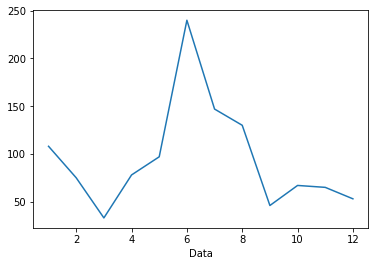

In [134]:
tmp.plot()

Tworzę zbiór pierwszych dwóch słów występujących w nazwie

In [105]:
words_set_first_two = set()

for name in df["Uproszczona nazwa produktu"].to_list():
    for word in name.split()[:2]:
        words_set_first_two.add(word)

In [109]:
len(words_set_first_two)

7283

In [110]:
# Słowa które znalazły się w banku słów word2vec:
included_words = []
# Słowa których word2vec nie zna
removed_words = []
# lista wektorów odpowiadających poszeczególnym słowom
words_array = []

for word in words_set_first_two:
    try:
        vec = word2vec[word]
        words_array.append(vec)
        included_words.append(word)
    except KeyError:
        removed_words.append(word)
        
words_array = np.array(words_array)
print(f"Udało się zakodować {len(included_words)}")
print(f"{len(removed_words)} słów nie znalazło się w bazie słów")

Udało się zakodować 3852
3431 słów nie znalazło się w bazie słów


In [129]:
removed_words

['b',
 'd`ella',
 'ramienia',
 'wstropowa',
 'szklanym',
 'leżak/ławka',
 'topikowa',
 'leggingsy',
 'gam',
 'listew',
 'c.blanche',
 'fotela',
 'herbatę',
 'wiszącahome',
 'lepienia',
 'kocie',
 'poliwęglanu',
 'rozciągany',
 'czaszka/głowa',
 'klipsów',
 'doniczki',
 'atłasowe',
 'atlasem',
 'stylizacji',
 'pldn',
 'sofę',
 'bystre',
 'meble',
 'drewnianą',
 'vinnic',
 'kanap',
 'klamerki',
 'spania',
 'podłogowa',
 'budzikiem',
 'kabli',
 'soehnle',
 'wiskozy',
 'f&home',
 'wózka',
 'otworów',
 'wiskoelastyczna',
 'kleju',
 'kółkach',
 'przeciwsłoneczne',
 'oczyszczająca',
 'kantarów',
 'makramy',
 'kafeterka',
 'pictureka',
 'fugi',
 'odchylane',
 'cyferkami',
 'miasta',
 'zakrętką',
 'kłódki',
 'tyczki',
 'tłoczona',
 'poduszką',
 'oczu',
 'bananagrams',
 'dwustopniowa',
 'okrgła',
 'celiane',
 'chrustu',
 'mistrzem',
 'ławka/sofa',
 'koralikami',
 'stojak/wieszak',
 'cecotec',
 'pierścieni',
 'r',
 'zwierzaki',
 'zasilająca',
 'kabin',
 'naciągu',
 'zabaw',
 'ks',
 'magnesem',
 '

In [153]:
clustering = DBSCAN(eps=0.22, min_samples = 10, metric = "cosine", algorithm="brute").fit(words_array)

# Słownik w którym kluczami są słowa, a wartościami numer klastra w którym znajduje się to słowo
word2cluster = dict()

# Słownik w którym kluczem jest numer klastra, a wartością lista słów w klastrze
cluster2word = collections.defaultdict(list)

for idx, word in enumerate(included_words):
    word2cluster[word] = clustering.labels_[idx]
    cluster2word[clustering.labels_[idx]].append(word)
    
print(f"Number of outliers: {len(cluster2word[-1])}")
for i in range(len(cluster2word) - 1):
    print(f"cluster {i}: {len(cluster2word[i])}")

Number of outliers: 3437
cluster 0: 93
cluster 1: 74
cluster 2: 96
cluster 3: 35
cluster 4: 57
cluster 5: 12
cluster 6: 13
cluster 7: 14
cluster 8: 11
cluster 9: 10


In [151]:
for i in range(len(cluster2word) - 1):
    print(f"Cluster {i}")
    print_cluster(cluster2word[i])
    print("\n")

Cluster 0
dzbanek, sakwa, szuflada, naczynie, koperta, talerze, pojemnik, cukiernica, półka, rondelek, lodówka, kasetka, regał, komoda, chochla, kredens, wiadro, łyżka, szklanka, naczynia, aktówka, toaletka, plecak, etui, worek, konewka, szafka, tortownica, termos, brytfanka, karafka, widelczyk, portfel, teczka, patelnia, schowek, neseser, puszka, kociołek, kanister, garnek, butelka, mydelniczka, beczka, kufer, notes, pudło, stojak, słoik, kosz, puszek, notatnik, skrzynka, piecyk, pudełko, kufel, komódka, sekretarzyk, torebka, talerz, sejf, kieliszek, menażka, łyżeczka, rondel, chlebak, misa, maselniczka, kawa, torba, półmisek, czajnik, stół, walizka, saszetka, koszyk, woreczek, opakowanie, brytfanna, bidon, etażerka, kubek, tacka, miska, rożen, szafa, kuferek, miseczka, skrzynia, foremka, filiżanka, chłodziarka, wiaderko, 


Cluster 1
elizabeth, lucy, ursula, dorothy, dickie, louise, penny, eva, patricia, bobbi, naomi, anita, sally, vivian, bob, agata, woody, pamela, natalie, wendy, m

### DBSCAN na pierwszych dwóch *skonkatenowanych* słowach

Działa mega wolno. Chyba lepiej nie używać.

In [142]:
# Słowa które znalazły się w banku słów word2vec:
included_names = []
# Słowa których word2vec nie zna
names_not_found = []
# lista wektorów odpowiadających poszeczególnym słowom
names_array = []

for name in df["Uproszczona nazwa produktu"].to_list():
    if len(name) >=2:
        name1 = name[0]
        name2 = name[1]
    else:
        name1 = name
        name2 = ""
    
    try:
        vec1 = word2vec[name1]
        #words_array.append(vec)
        #included_words.append(word)
    except KeyError:
        vec1 = None
        #removed_words.append(word)
    try:
        vec2 = word2vec[name2]
    except KeyError:
        vec2 = None
        
    if (vec1 is not None) and (vec2 is not None):
        names_array.append(np.concatenate((vec1, vec2)))
        included_names.append(" ".join([name1, name2]))
    
    elif (vec1 is not None) and (vec2 is None):
        names_array.append(np.concatenate((vec1, vec1)))
        included_names.append(" ".join([name1, "."]))
        
    elif (vec1 is None) and (vec2 is not None):
        names_array.append(np.concatenate((vec2, vec2)))
        included_names.append(" ".join([".", name2]))
    
    else:
        names_not_found.append(" ".join([name1, name2]))
        
        
names_array = np.array(names_array)
print(f"Udało się zakodować {len(included_names)} nazw")
print(f"Nie udało się zakodować {len(names_not_found)} nazw")

Udało się zakodować 126563 nazw
Nie udało się zakodować 20308 nazw


In [ ]:
clustering = DBSCAN(eps=0.3, min_samples = 5, metric = "cosine").fit(names_array)

print("Klastry: ")
print(set((clustering.labels_)))

### Załóżmy, że mamy kategorie produktów. Co dalej?

In [26]:
agd_cluster = ['spryskiwacz',
                 'kuchenka',
                 'dmuchawa',
                 'kaloryfer',
                 'podgrzewacz',
                 'grzejnik',
                 'kompresor',
                 'pompa',
                 'palnik',
                 'wentylator',
                 'klimatyzator',
                 'termostat']

In [27]:
mask = df["Uproszczona nazwa produktu"].apply(lambda x: True if any(word in x.lower().split() for word in agd_cluster) else False)

In [28]:
mask.sum()

1440

In [29]:
agd_sells_volume = df[mask]["ID zamówienia"].groupby(df["Data"].dt.month).nunique()

In [22]:
import matplotlib.pyplot as plt

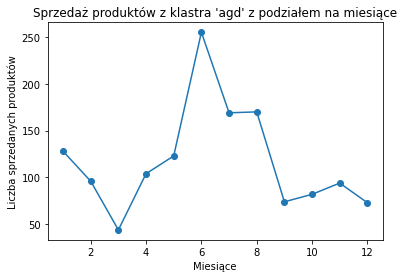

In [34]:
agd_sells_volume.plot(marker="o")
plt.title("Sprzedaż produktów z klastra 'agd' z podziałem na miesiące")
plt.xlabel("Miesiące")
plt.ylabel("Liczba sprzedanych produktów")
plt.show()